## Visualising ConvNets - Part 1

This notebooks aims to understand the functioning of Convolutional Neural networks on a global basis.

In [22]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
%matplotlib inline
plt.rcParams['figure.figsize']=[10,10]

# Keras specific imports
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.utils import np_utils

In [23]:
# Import and test-run
from tinyVGG.model import tinyVGGNet

# load some utilities for making dataset work nice with Keras
from helpers.utils import genmplImg, load_CIFAR10, oneHot, reformat, unpickle, reformat_wts

load_wts = True
model = tinyVGGNet.build(width=32,height=32,depth=3,classes=10)

if load_wts:
    model.load_weights('./weights-improvement-11-0.75.hdf5')

# print a summary of the model
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_7 (ZeroPadding2D)  (None, 3, 34, 34)     0           zeropadding2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 16, 32, 32)    448         zeropadding2d_7[0][0]            
____________________________________________________________________________________________________
zeropadding2d_8 (ZeroPadding2D)  (None, 16, 34, 34)    0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 16, 32, 32)    2320        zeropadding2d_8[0][0]            
___________________________________________________________________________________________

### Data I/O

We use the utility provided by Stanford's cs231n assignments to load up the dataset. The Dataset is loaded up in the format of (batch_size, 32, 32, 3) but keras model fitting routines expect an input size of (batch_size, 3, 32, 32), hence we use the reformat function in helpers/utils.py to correct the data format.

Also, Keras uses one-hot encoding i.e (0,0,1,0,0,0,0,0,0,0) for the data labels. The utility <em>np_utils.to_categorical</em> provided by Keras does the job for us. This is wrapped in a convenience function oneHot(dat).  

In [24]:
X_train, y_train, X_test, y_test = load_CIFAR10('./cifar-10-batches-py/')
labels = unpickle('./cifar-10-batches-py/batches.meta')['label_names'] 

# Reformatting dataset to size (batch, 3, 32, 32)
trainData = reformat(X_train)
testData  = reformat(X_test)

trainLabels = oneHot(y_train)
testLabels  = oneHot(y_test)

print trainData.shape,'\n' , testData.shape,'\n' , trainLabels.shape,'\n' , testLabels.shape
print 'Labels-> ',labels

(50000, 3, 32, 32) 
(10000, 3, 32, 32) 
(50000, 10) 
(10000, 10)
Labels->  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Running the network through some test images

We run the pre-trained network through some test images to see how well it performed. 

<em>Note. the images are tagged below as <b>(Predicted Label / Actual label)</b></em>  

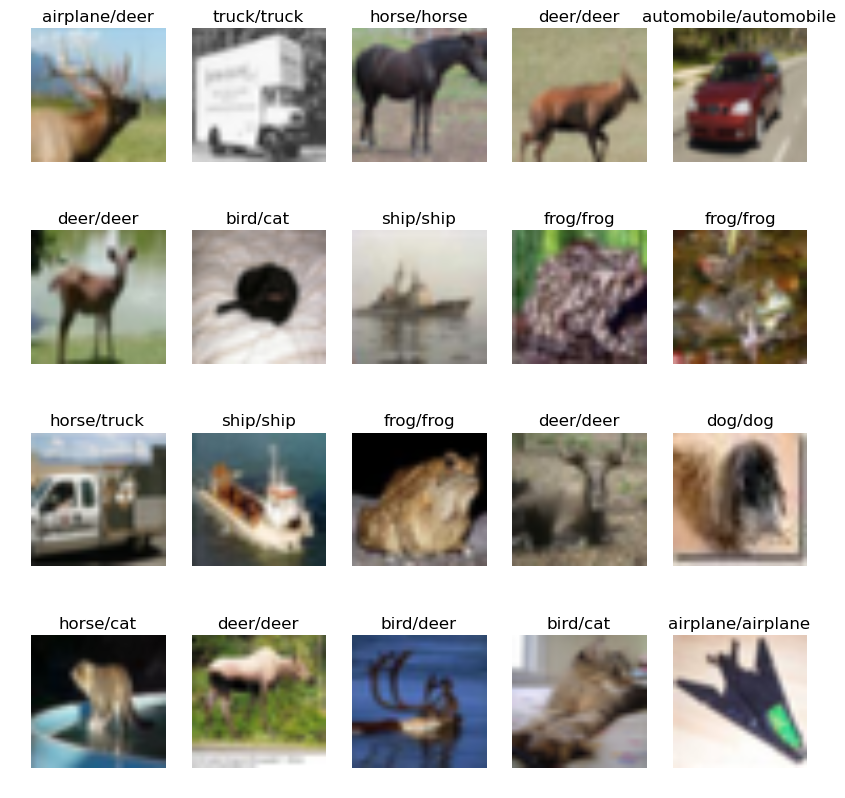

In [25]:
# Visualise some test images 
for i in xrange(20):
    idx = np.random.randint(0,testData.shape[0])
    scores = model.predict(testData[idx:idx+1])
    label_predicted  = labels[np.argmax(scores)]
    label_actual     = labels[np.argmax(testLabels[idx])]
    
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[idx]*255)
    plt.title(label_predicted+"/"+label_actual)
    plt.axis('off')
plt.show()

In [58]:
# Occlusion generator function
def generateOccludedImages(inputImg, f = 4):
    '''Generate a set of images wherein a black square (of given side) occludes a part of the image'''
    imgSet = []
    for i in xrange(0, inputImg.shape[0]-f+1, f):
        for j in xrange(0, inputImg.shape[1]-f+1, f):
            maskedImg = np.copy(inputImg)
            maskedImg[i:i+f , j:j+f] = 0
            imgSet.append( [ maskedImg , (i,i+f,j,j+f) ] )
            del maskedImg
    return imgSet

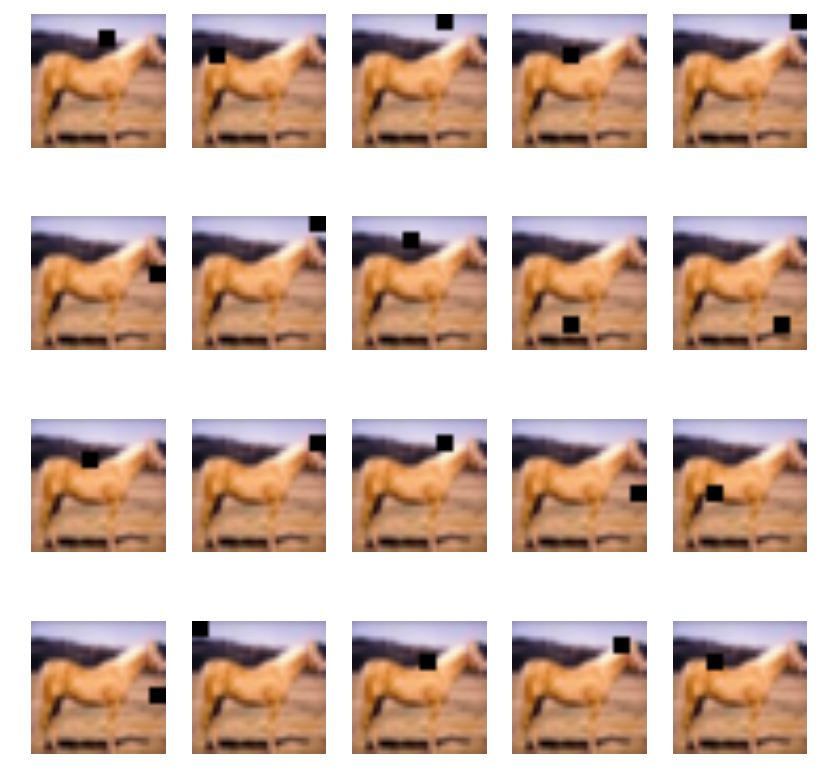

In [92]:
# display some occluded images
testImg = X_test[700]
imgSet  = generateOccludedImages(testImg,f=4)
plt.rcParams['figure.figsize']=[10,10]
for i in xrange(20):
    plt.subplot(4,5,i)
    plt.imshow(imgSet[np.random.randint(len(imgSet))][0]*255)
    plt.axis('off')
plt.show()

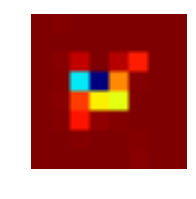

In [93]:
# pass these occluded images through the model and store the correct class scores in a heat map
heatMap = np.zeros(testImg.shape[0:2])
occludedImgs = np.array([val[0] for val in imgSet])
occludedImgs = reformat(occludedImgs)
scores = model.predict(occludedImgs)
correct_class_scores = scores[:,np.argmax(testLabels[700])]
for i in xrange(occludedImgs.shape[0]):
    loc = imgSet[i][1]
    heatMap[loc[0]:loc[1], loc[2]:loc[3]] = correct_class_scores[i]
plt.rcParams['figure.figsize']=[2,2]
plt.imshow(heatMap)
plt.axis('off')
plt.show()


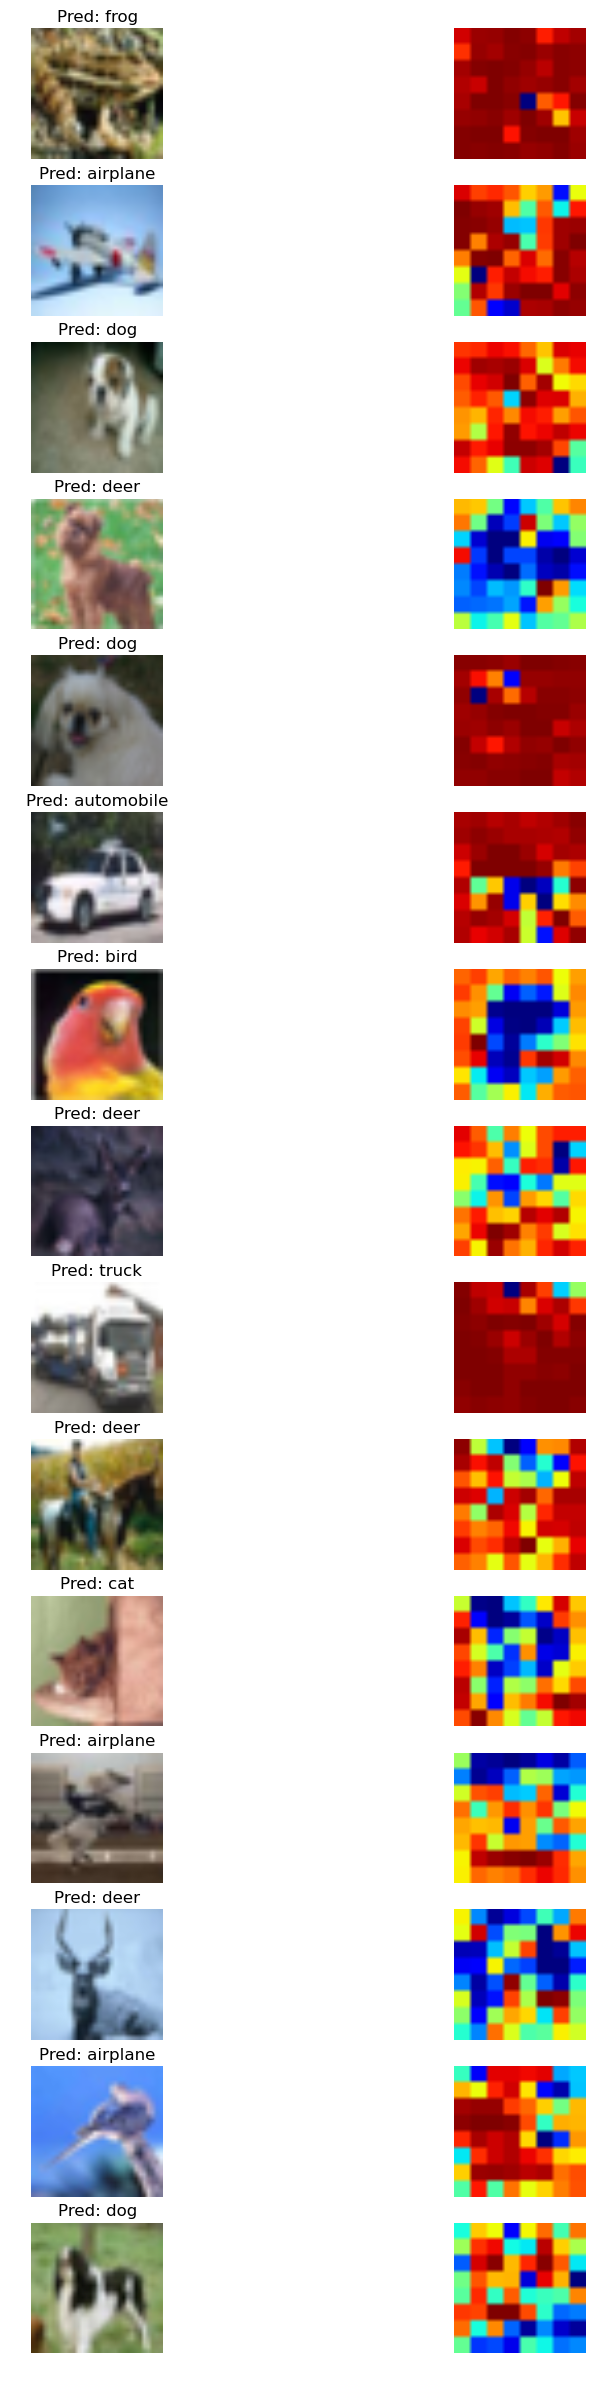

In [118]:
plt.rcParams['figure.figsize']=[10,30]



for i in xrange(15):
        
    idx = np.random.randint(10000)
    img = X_test[idx]
    imgSet = generateOccludedImages(img,f=4)
    pred   = np.argmax(model.predict(testData[idx:idx+1]))

    heatMap = np.zeros(testImg.shape[0:2])

    occImgs = reformat(np.array([val[0] for val in imgSet]))
    scores  = model.predict(occImgs)
    correct_class_scores = scores[:,pred]

    for j in xrange(len(imgSet)):
        loc = imgSet[j][1]
        heatMap[loc[0]:loc[1], loc[2]:loc[3]] = correct_class_scores[j]

    plt.subplot2grid((15,2),(i,0))
    plt.axis("off")
    plt.title("Pred: "+labels[pred])
    plt.imshow(img*255)
    plt.subplot2grid((15,2),(i,1))
    plt.axis("off")
    plt.imshow(heatMap)
    

plt.show()